# Deep Q-Learning

We can solve Grid World, that's awesome: we have agents that learn! So let's have them learn how to
play Atari video games, such as pong!

But... Grid World has a state space of ~20... Atari games have a state space of ~$10^{17000}$ using
pixels (consider that there are ~$10^{82}$ atoms in the observable universe). Tabular methods don't
scale to such large spaces.

To overcome this limitation, we will use function approximation and approximate the Q function using
neural networks!

**Prerequisites**: Neural Network fundamentals as well as PyTorch basic APIs.

## Gymnasium and Atari Pong

[Gymnasium](https://gymnasium.farama.org/index.html) is an API standard for reinforcement learning,
with a vast collections of environments. Let's use it!

In [2]:
!pip install ale-py
!pip install gymnasium

from ale_py import ALEInterface
ale = ALEInterface()
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 41.5 MB/s eta 0:00:00


# GYMNASIUM EXPS

In [32]:
env = gym.make('ALE/Pong-v5')
obs, info = env.reset()

In [33]:
obs, info = env.reset()

In [19]:
sample_action = env.action_space.sample()

In [20]:
env.action_space, sample_action

(Discrete(6), 3)

0.0


array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       [[144,  72,  17],
        [144,  72,  17],
        [144,  72,  17],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       [[144,  72,  17],
        [144,  72,  17],
        [144,  72,  17],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       ...,

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]]], dtype=uint8)
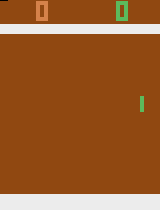

In [34]:
obs, reward, terminated, truncated, info = env.step(1)
print(reward)
obs

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       [[144,  72,  17],
        [144,  72,  17],
        [144,  72,  17],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       [[144,  72,  17],
        [144,  72,  17],
        [144,  72,  17],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       ...,

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]]], dtype=uint8)
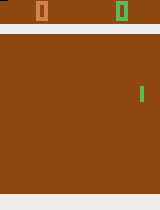

In [35]:
obs, reward, terminated, truncated, info = env.step(4)
obs

In [36]:
reward

0.0

# UTILS FILE

In [3]:
import gymnasium as gym
import gymnasium.utils.seeding as seeding
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tempfile
import torch

from IPython.display import Image
from collections import deque
from gymnasium.wrappers import RecordVideo
from moviepy.editor import VideoFileClip
from typing import NamedTuple

# The device to use for PyTorch. Just defined here for convenience.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# The default random seed used in the lectures.
DEFAULT_RANDOM_SEED=10

def init_random(env: gym.Env=None, seed=DEFAULT_RANDOM_SEED):
    """Initializes all the random generators used by frameworks to a default value.

    If `env` is specified, it sets also the env random generator and return the env itself. That is
    just a convenient setup for the notebooks, even if arguably not the best structured code setup.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.use_deterministic_algorithms(True)
    if env is not None:
        env.np_random, _ = seeding.np_random(seed)
        env.reset(seed=seed)
    return env

def epsilon_gen(eps_start=1.0, eps_decay=0.99999, eps_min=0.05):
    """Generator function for Ɛ and its decay (e.g., exploration via Ɛ-greedy policy)."""
    eps = eps_start
    while True:
        yield eps
        eps = max(eps * eps_decay, eps_min)

def soft_update_model_params(src: torch.nn.Module, dest: torch.nn.Module, tau=1e-3):
    """Soft updates model parameters (θ_dest = τ * θ_src + (1 - τ) * θ_src)."""
    for dest_param, src_param in zip(dest.parameters(), src.parameters()):
        dest_param.data.copy_(tau * src_param.data + (1.0 - tau) * dest_param.data)

class Experience(NamedTuple):
    """A single step / experience of an agent stored in the replay buffer."""
    state:      np.array
    action:     float
    reward:     float
    next_state: np.array
    done:       bool

class ReplayBuffer:
    """Simple replay buffer for off-policy deep reinforcement learning algorithms.

    IMPORTANT: This ReplayBuffer is specifically tuned for the DDPG / TD3 / SAC algorithms in these
    lectures. In particular, the action space is a single float scalar. If you want to adapt those
    algorithms to different environments, you will need to update this code accordingly as well.
    """
    def __init__(self, buffer_size=int(1e5)):
        """Initializes the buffer with an internal deque of size `buffer_size`."""
        self.memory = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        """Stores a single step / experience of an agent."""
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size: int = 128):
        """Randomly selects `batch_size` items from the buffer, stacks them, and returns them."""
        all_indices = np.arange(len(self.memory))
        selection = np.random.choice(all_indices, size=batch_size)
        return self.unpack(selection)

    def unpack(self, selection):
        """Given the `selection` of experiences, returns them as a tuple of stacked values.

        This is convenient for the usage in the various learning algorithms so that they don't have
        to do it themselves.
        """
        experiences = [e for i in selection if (e := self.memory[i]) is not None]
        states, actions, rewards, next_states, dones = zip(*experiences)
        states      = torch.from_numpy(np.stack(states)).float().to(DEVICE)
        actions     = torch.from_numpy(np.vstack(actions)).float().to(DEVICE) # NOTE: float scalar!
        rewards     = torch.from_numpy(np.vstack(rewards)).float().to(DEVICE)
        next_states = torch.from_numpy(np.stack(next_states)).float().to(DEVICE)
        dones       = torch.from_numpy(np.vstack(dones, dtype=np.uint8)).float().to(DEVICE)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

def show_gym_video_recording(name_prefix: str = 'rl-video', folder: str = None):
    """Shows the recorded video of episode 0 of a gym environment."""
    if folder == None:
        folder = tempfile.tempdir
    video_file = os.path.join(folder, f'{name_prefix}-episode-0.mp4')
    video_clip = VideoFileClip(video_file)
    gif_file = os.path.join('./', 'rl-video.gif')
    video_clip.write_gif(gif_file, fps=15)
    video_clip.close()
    return Image(open(gif_file, 'rb').read())

def plot_scores(scores, rolling_window=25):
    """Plots training scores and their running average."""
    avgs = pd.Series(scores).rolling(rolling_window).mean()
    x = np.arange(len(scores))
    plt.figure('Episode scores')
    plt.plot(x, scores, label='Scores')
    plt.plot(x, avgs, 'r', label='Running average')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    return plt.show()

def gym_simulation(env_name: str, agent=None, max_t=1_000, env_kwargs={}):
    """Runs a simulation of an agent in an initialized gym environment and plays the video."""
    sim_env = gym.make(env_name, render_mode="rgb_array_list", **env_kwargs)
    sim_env = init_random(sim_env)
    sim_env = RecordVideo(sim_env, './', lambda i: i == 0)
    state, _ = sim_env.reset()
    for _ in range(max_t):
        action = agent.act(state) if agent is not None else sim_env.action_space.sample()
        next_state, _, terminated, truncated, _ = sim_env.step(action)
        if terminated or truncated:
            break
        state = next_state
    sim_env.close()
    return show_gym_video_recording()

  if event.key is 'enter':



# Assigment

In [4]:
import random
import tempfile

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, RecordVideo

# from util.gymnastics import DEVICE, init_random, plot_scores, show_gym_video_recording

In [5]:
# FIND THESE ON THE ABOVE UTIL FILE CELL
DEVICE, init_random, plot_scores, show_gym_video_recording

(device(type='cpu'),
 <function __main__.init_random(env: gymnasium.core.Env = None, seed=10)>,
 <function __main__.plot_scores(scores, rolling_window=25)>,
 <function __main__.show_gym_video_recording(name_prefix: str = 'rl-video', folder: str = None)>)

In [6]:
# Let's learn Gymnasium! https://gymnasium.farama.org/environments/atari/pong/

def gym_simulate(agent = None):
    """Runs an Atari pong game with our agent passed as input."""
    # We use pong deterministic b/c it is simpler to train.
    # Actions: NOOP, FIRE, RIGHT, LEFT, RIGHTFIRE, LEFTFIRE
    # TODO: Use gym.make to create "PongDeterministic-v4" environment. Also, pass the render_mode
    #       'rgb_array_list' and frameskip=1 to make sure we can record the video :)
    sim_env = gym.make('PongDeterministic-v4', render_mode = 'rgb_array_list', frameskip = 1)
    # Initializes the random generators for determinism.
    sim_env = init_random(sim_env)
    # TODO: Add the preprocessor for Atari. This does black/white conversion, and other convenient
    #       operations for learning (see documentation).
    sim_env = AtariPreprocessing(sim_env, )
    # Adding the RecordVideo wrapper to be able to record videos.
    sim_env = RecordVideo(sim_env, './', lambda i: i == 0)

    # TODO: Reset the environment
    init_position, _ = sim_env.reset()
    # TODO: Take the first step with action=1 that starts the game.
    first_observation, _, _, _, _ = sim_env.step(1)
    # TODO: To create the state, we stack two observations, that is to have a sense of time/velocity
    #       for the pong game. Hint: use np.stack.
    state = np.stack([init_position, first_observation])

    print(state.shape)

    for _ in range(2_500):
        # TODO: Call agent.act if the agent is specified, otherwise use action_space.sample() from
        #       the gym environment to select a random action.
        if agent:
            action = agent.act(state)
        else:
            action = sim_env.action_space.sample()
        # TODO: Perform an environment step.
        observation, _, terminated, truncated, _ = sim_env.step(action)
        # TODO: Check for completion, if completed reset the environment.
        if terminated or truncated:
            observation, _ = sim_env.reset()
        # TODO: Update the state with the new stacked observations (the last and the new one)
        state = np.stack([state[-1], observation])

    # TODO: Remember to close the gym environment!
    sim_env.close()
    # Call a convenient utility function to show the video in the notebook as a GIF.
    return show_gym_video_recording(folder = './')

  logger.warn(



(2, 84, 84)
MoviePy - Building file ./rl-video.gif with imageio.


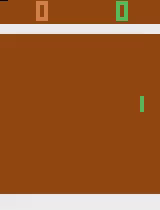

In [7]:
gym_simulate()

## DQN

### Q Function Approximation via Neural Network

Instead of a "lookup" table, $Q$ is going to be a parameterized functions: $Q_\theta(s,a)$. The set
of parameters $\theta$ corresponds to the parameters (e.g., weights) of the neural network trained
to approximate $Q$.

We cannot use the TD error $\delta^{TD}$ to update $Q$ anymore, because we now have to optimize the
set of parameters $\theta$ instead. The target is still the following:
$$
target(s') = R(s, a, s') + \gamma \max_{a'} Q_{\theta_{k}}(s', a')
$$

But now we use gradient descent to update the parameters $\theta$ (in a sense still minimizing
$\delta^{TD}$):
$$
\theta_{k+1} = \theta_k - \alpha \nabla_\theta
   \biggl\{ \frac{1}{2} \Bigl[ Q_\theta(s,a) - target(s') \Bigr] ^ 2 \biggr\}
$$

Luckily, we don't have to implement any neural networks or know automatic differentiation math
ourselves thanks to modern frameworks like PyTorch, TensorFlow, JAX! We use PyTorch in this course.

In [15]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, action_size):
        super(QNetwork, self).__init__()
        # TODO: Recall that the state is 2 frames of 84x84 pixels, which translates into a 2x84x84
        #       tensor. Let's run 2D convolutions to transform to 4x40x40 and then 16x9x9. To do
        #       that, add two Conv2d layers with (out_channels, kernel_size, stride) to match those
        #       dimensions. Hint: (size - kernel) / stride + 1

        self.device = DEVICE

        self.enc = nn.Sequential(
            nn.Conv2d(2, 4, kernel_size = 7, stride = 2, padding = 3), # 4, 42, 42
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size = 3, stride = 2, padding = 1), # 8, 21, 21
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 2, padding = 1), # 16, 11, 11
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 2, padding = 1), # 16, 6, 6
            nn.Flatten(),
        ).to(self.device)

        # TODO: Create two fully connected layers with 256 and action_size units.
        self.mlp = nn.Sequential(
            nn.Linear(576, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
        ).to(self.device)

    def forward(self, x):
        """Build a network that maps state -> action values."""

        if x.ndim < 4: # its not a batch, its a single example, make it a batch
            x = x[None, :, :, :]
        # TODO: Forward through the convolutions (use ReLU non-linearity)
        # TODO: Remember to flatten the tensor for the linear layers!
        # TODO: Forward through linear layers (using ReLU again)
        # TODO: The output is directly the output of the last linear layer, representing the
        #       action value function.

        x = x.to(self.device)
        # breakpoint()
        inter = self.enc(x)
        action_space = self.mlp(inter)

        return action_space

In [16]:
# Test for neural network!
init_random()

test_net = QNetwork(action_size=6)

fake_img = np.random.randn(2, 84, 84)
fake_tensor = torch.from_numpy(fake_img).float()
result = test_net.forward(fake_tensor).detach()

expected_result = torch.tensor([[-0.2041,  0.0406, -0.0483,  0.0051,  0.0216,  0.0395]])
assert expected_result.shape == result.shape
# assert torch.allclose(result, expected_result, atol=0.0001)
# result

### Algorithm

The algorith from the [2013 paper](https://arxiv.org/abs/1312.5602) is approximately the following:

<div style="width: 50%">
  <img src="https://github.com/pranay8297/drl-zh/blob/main/assets/03_DQN_algo_highlighted.png?raw=1">
  <br>
  <small></small>
</div>

Two techniques to highlight:

 * **Replay Buffer:** Helpful for data efficiency (data reused for many updates). Also, learning
   from consecutive samples is inefficient because of the strong correlations. Using a replay buffer
   and randomizing the samples breaks such correlations reducing variance of the updates. It helps
   preventing _catastrophic forgetting_.
 * **Target Network:** We don't update the same network at every step, because the target would
   effectively become non-stationary (e.g., dog chasing its own tail) and learning become unstable.
   Instead, we keep the "target" stable for a while, and then (every _C_ steps) we update it to the
   current parameters.

We can see how the _blue_ box is mostly equivalent to Q Learning, but the _red_ part of the learning
algorithm runs gradient descent on the Q network parameters.

### Replay Buffer

In [17]:
from collections import deque
from typing import NamedTuple

class Experience(NamedTuple):
    """An Experience stored in the replay buffer."""
    state:      np.array
    action:     int
    reward:     float
    next_state: np.array
    done:       bool

class ReplayBuffer:
    """The replay buffer for DQN."""
    def __init__(self, buffer_size=int(1e4)):
        self.memory = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        # TODO: Append a new Experience in the memory.
        exp = Experience(state, action, reward, next_state, done)
        self.memory.append(exp)
        pass

    def sample(self, batch_size: int = 32):
        # TODO: Select a new batch of experiences from the memory.
        #       Hint: use np.arange and np.random.choice.
        all_indices = np.arange(len(self.memory))
        selection = np.random.choice(all_indices, batch_size)
        return self.unpack(selection)

    def unpack(self, selection):
        # TODO: Select the experiences from the memory (filtering out missing indexes).
        # experiences =
        # selection = list(selection)
        states, actions, rewards, next_states, dones = zip(*([torch.from_numpy(self.memory[i].state).to(torch.float32) if not isinstance(self.memory[i].state, torch.Tensor) else self.memory[i].state,
                                                         self.memory[i].action,
                                                         self.memory[i].reward,
                                                         torch.from_numpy(self.memory[i].next_state).to(torch.float32) if not isinstance(self.memory[i].next_state, torch.Tensor) else self.memory[i].next_state,
                                                         self.memory[i].done] for i in selection))
        # TODO: Convert the selections to PyTorch tensors, stacking the arrays.
        #       Hint: use torch.from_numpy and np.stack/vstack (in case of scalars). Also, remember
        #       to convert to the appropriate tensor type (float() or long())
        # breakpoint()
        states      = torch.stack(states)
        actions     = torch.tensor(actions)[:, None].to(torch.long).to(DEVICE)
        rewards     = torch.tensor(rewards)[:, None].to(torch.float32).to(DEVICE)
        next_states = torch.stack(next_states)
        dones       = torch.tensor(dones)[:, None].to(torch.long).to(DEVICE)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        # TODO: Returns the number of experiences in the replay buffer.
        return len(self.memory)

In [18]:
# Replay buffer minimal test.
test_buffer = ReplayBuffer()

def fake_state():
    return np.random.rand(4, 5)

test_buffer.add(fake_state(), 10, 1.0, fake_state(), False)
test_buffer.add(fake_state(), 11, 2.0, fake_state(), False)
test_buffer.add(fake_state(), 12, 3.0, fake_state(), False)
test_buffer.add(fake_state(), 13, 4.0, fake_state(), False)
test_buffer.add(fake_state(), 14, 5.0, fake_state(), True)

batch_size = 3
state_shape = (batch_size, 4, 5)

t_states, t_actions, t_rewards, t_next_states, t_dones = test_buffer.sample(batch_size)

assert t_states.shape      == state_shape
assert t_actions.shape     == (batch_size, 1)
assert t_rewards.shape     == (batch_size, 1)
assert t_next_states.shape == state_shape
assert t_dones.shape       == (batch_size, 1)

### Training Loop

In [19]:
def start_episode(env: gym.Env):
    """Method to call to start a new episode for pong in DQN training."""
    state, _ = env.reset()
    obs, _, _, _, _ = env.step(1) # Starts the game :)
    return torch.from_numpy(np.stack([state, obs])).to(torch.float32).to(DEVICE) # always on GPU

In [20]:
# from util.gymnastics import epsilon_gen

epsilon_gen

def train(env, agent, max_timesteps=int(1e6)) -> list[int]:
    # Records all episode scores.
    scores = []
    # Tracks the current episode score.
    score  = 0.0
    # Tracks the current episode number.
    n_episode = 1
    # TODO: Create the epsilon generator. Start: 0.1, decay: 0.995, min: 0.01.
    eps_gen = epsilon_gen(0.1, 0.95, 0.01)

    # TODO: Get the next epsilon.
    epsilon = next(eps_gen)
    # TODO: Get the first state.

    state = start_episode(env) # there is no batch here - important thing to remember - very very important

    # Run DQN training for max_timesteps.
    for t in range(max_timesteps):
        # TODO: Select an action calling agent.act passing state and epsilon.
        action = agent.act(state, epsilon)
        # TODO: Make a step in the environment with the selection action.
        observation, reward, terminated, truncated, _ = env.step(action)
        # TODO: Build the new state (i.e., two stacked frames).
        next_state = torch.stack([state[-1], torch.from_numpy(observation).to(torch.float32).to(DEVICE)]) # 2, 84, 84
        # Determines if the episode ended
        done = terminated or truncated
        # TODO: Call agent.step with (state, action, reward, next_state, done). That will take care
        #       of collecting experiences and learning - we'll see later :)

        agent.step(state, action, reward, next_state, done)
        # Prepares for the next iteration, updating score and state, and checking for completion.
        state = next_state
        score += reward
        if done: # Ends the episode
            scores.append(score)
            avg = np.mean(scores[-25:])
            print(f'\rEpisode {n_episode}\tScore: {score:.2f}\tT={t:6} (avg={avg:.2f})',
                  end="\n" if n_episode % 25 == 0 else "")
            score = 0.0
            n_episode += 1
            epsilon = next(eps_gen)
            state = start_episode(env)

    # Checkpoint the agent at the end of training, also save the scores for plotting.
    agent.checkpoint()
    np.savetxt("dqn_scores.csv", np.asarray(scores, dtype=np.int16), delimiter=",")
    return scores

### Agent Code

In [21]:
class Agent:
    """Agent that interacts with and learns from the environment."""

    def __init__(self, action_size=6, gamma: float = 0.99, tau: float = 1e-3, lr: float = 1e-4,
                 batch_size: int = 32, learn_every: int = 4, update_target_every: int = 2,
                 preload_file: str = None):

        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau
        self.lr = lr
        self.batch_size = batch_size
        self.learn_every = learn_every # grad accum steps?
        self.update_target_every = update_target_every # c
        self.t_learn_step = 0 # number of times the network is updated
        self.t_update_target_step = 0 # number of times target network is updated

        # TODO: Create the replay buffer.
        self.memory = ReplayBuffer()

        # TODO: Create both the local and target networks.

        self.qnetwork_local  = QNetwork(action_size)
        self.qnetwork_target = QNetwork(action_size)

        # self.qnetwork_local.zero_grad()

        # TODO: Copy the weights of the local network in the target one. Hint use state_dict() and
        #       load_state_dict methods.
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        # TODO: Remember to set the target network only in eval mode.
        self.qnetwork_target.eval()

        # Creating the optimizer.
        self.optimizer = optim.AdamW(self.qnetwork_local.parameters(), lr=self.lr, betas = (0.9, 0.999), eps = 1e-05)
        self.optimizer.zero_grad()

        # If we want to preload a saved network, we do it here.
        if preload_file is not None:
            print(f'Loading pre-trained model: {preload_file}')
            self.qnetwork_local.load_state_dict(torch.load(preload_file, map_location=DEVICE))

    def step(self, state, action, reward, next_state, done):
        """Tells the agent to make a step: record experience and possibly learn."""
        # TODO: Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        # TODO: Update t_learn_step to determine when to learn (every "learn_every" time steps).

        if self.t_learn_step % self.learn_every == 0 and len(self.memory) > self.batch_size:
            # TODO: If enough samples are available in memory, get random subset and learn.
            self.learn()

        # Update target network every "update_target_every" step.
        if (self.t_update_target_step + 1) % self.update_target_every == 0:
            Agent.soft_update_model_params(self.qnetwork_local, self.qnetwork_target, self.tau)

        self.t_learn_step += 1

    def act(self, state: np.array, eps=0.):
        """Makes the agent take an action for the state passed as input."""
        # TODO: Convert the state to a torch.Tensor
        if not isinstance(state, torch.Tensor):
            state = torch.from_numpy(state).to(torch.float32).to(DEVICE) # (2, 84, 84) - one single output

        # TODO: Set the local network to eval, probe it to get the action values, and set it back
        #       to training mode. Remember to use torch.no_grad().
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state) # [1, 6]

        # TODO: Perform epsilon-greedy action selection based on eps.
        #       Hint: either np.argmax or random.choice across all actions.
        flag = random.random() < eps
        if flag: # select random
            action = np.random.randint(self.action_size) # single int value
        else: # argmax actions
            action = action_values.argmax().item() # single integer value # GPU check done

        return action

    def learn(self): # happens as a batch - unlike others
        """Executes one learning step for the agent."""
        # TODO: Select a batch of experiences from the replay buffer
        # print("Learning")
        experiences = self.memory.sample(self.batch_size) # (state, action, reward, next_state, done) # batch_size
        # TODO: Unpack them
        states, actions, rewards, next_states, dones = experiences

        self.qnetwork_local.train()

        with torch.no_grad():
            # TODO: Get the predicted action values of the *NEXT* states from the target model.
            target_action_values = self.qnetwork_target(next_states) # (batch_s, action_s)
            # TODO: Select the max action value for each state:
            #       Hint: https://pytorch.org/docs/stable/generated/torch.amax.html
            max_action_values = target_action_values.amax(dim = 1, keepdim = True)  # (batch_size, 1)
            # TODO: Then, compute the Q _targets_ for the current states.
            Q_targets = rewards + self.gamma*max_action_values # (batch_size, 1)

        # TODO: Get the predicted Q values from local model...
        predictions = self.qnetwork_local(states) # bs, action_space
        # TODO: ...but choose only the action value that was selected in the experience replay.
        # actions - bs, 1
        Q_expected = predictions.gather(1, actions)
        # TODO: Compute loss. Hint: use the Huber Loss.

        # breakpoint()
        loss = F.huber_loss(Q_expected, Q_targets)

        # TODO: Minimize the loss. Hint: zero_grad the optim, backward on loss, step the optim.
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # print(f"Loss: {loss.item()}")
        self.t_update_target_step += 1

    @staticmethod
    def soft_update_model_params(src: torch.nn.Module, dest: torch.nn.Module, tau=1e-3):
        """Soft updates model parameters (θ_dest = τ * θ_src + (1 - τ) * θ_dest)."""
        # TODO: For each dest parameter (get them via the parameters() function), update it with
        #       the update-rule in the method description. Hint: use data.copy_ of the parameter.
        with torch.no_grad():
            for src_p, dest_p in zip(src.parameters(), dest.parameters()):
                dest_p.data.copy_(tau*src_p.data + (1 - tau)*dest_p.data)

    def checkpoint(self):
        """Save the QNetwork weights in a file."""
        torch.save(self.qnetwork_local.state_dict(), 'dqn_weights.pth')

### Run Training and Simulation!

In [18]:
def pretrained_simulation():
    pretrained_agent = Agent(preload_file='solution/dqn_weights_pre.pth')
    pretrained_scores = np.loadtxt(f'solution/dqn_scores_pre.csv', delimiter=',').astype(np.int16)
    plot_scores(pretrained_scores)
    return gym_simulate(pretrained_agent)

# Uncomment the line below to watch the pretrained agent :)
# pretrained_simulation()

In [22]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

Episode 25	Score: -21.00	T= 21040 (avg=-20.68)
Episode 50	Score: -20.00	T= 47628 (avg=-18.92)
Episode 75	Score: -16.00	T= 85702 (avg=-17.60)
Episode 100	Score: -11.00	T=131644 (avg=-13.84)
Episode 125	Score: -12.00	T=182806 (avg=-11.28)
Episode 150	Score: -5.00	T=241494 (avg=-6.48)
Episode 175	Score: -6.00	T=293454 (avg=-9.72)
Episode 200	Score: -7.00	T=349327 (avg=-8.56)
Episode 225	Score: -11.00	T=398516 (avg=-10.28)
Episode 250	Score: -5.00	T=449580 (avg=-8.60)
Episode 275	Score: -8.00	T=501977 (avg=-7.32)
Episode 300	Score: 5.00	T=556554 (avg=-6.60)
Episode 325	Score: -8.00	T=608162 (avg=-4.04)
Episode 350	Score: -11.00	T=657814 (avg=-9.68)
Episode 375	Score: -7.00	T=713180 (avg=-6.72)
Episode 400	Score: 3.00	T=777442 (avg=-0.08)
Episode 425	Score: 17.00	T=838349 (avg=2.48)
Episode 450	Score: -17.00	T=889659 (avg=-2.84)
Episode 475	Score: 16.00	T=943267 (avg=7.52)
Episode 500	Score: 13.00	T=991039 (avg=9.36)
Episode 504	Score: 3.00	T=999982 (avg=6.04)

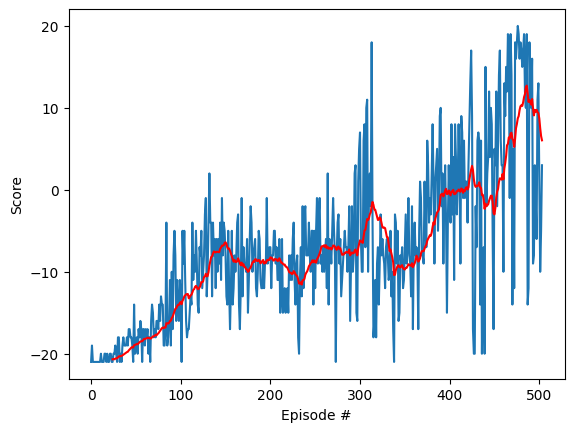

In [23]:
with gym.make("PongDeterministic-v4", frameskip=1) as env:
    # torch.use_deterministic_algorithms(True)
    env = init_random(env)
    env = AtariPreprocessing(env)
    agent = Agent(action_size=env.action_space.n, batch_size = 64, lr = 5e-04)
    scores = train(env, agent)

plot_scores(scores)

  logger.warn(



(2, 84, 84)
MoviePy - Building file ./rl-video.gif with imageio.


t:  99%|█████████▉| 935/941 [00:00<00:00, 1252.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./rl-video-episode-0.mp4, 100800 bytes wanted but 0 bytes read,at frame 1880/1881, at time 62.67/62.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



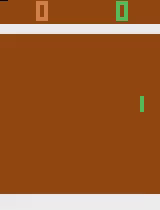

In [24]:
gym_simulate(agent)

## Where To Go From Here

 * Some tricks: e.g., acting only every other step and collect two steps help speeding up and
   stabilizing the training.
 * Improvements: prioritized experience reply, double DQN, up to Rainbow.
 * Check out official implementations such as Stable Baselines.